<a href="https://colab.research.google.com/github/mahima-c/GAN-Generative-Adversarial-Networks/blob/main/6_1VanillaGAN_pynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

MNIST using GAN in TensorFlow


Let us build a simple GAN capable of generating handwritten digits. We will use the MNIST handwritten digits to train the network. We use the TensorFlow Keras dataset to access the MNIST data. The data contains 60,000 training images of handwritten digits each of size 28 × 28. The pixel value of the digits lies between 0-255; we normalize the input values such that each pixel has a value in range [-1, 1]:

In [ ]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import initializers


import matplotlib.pyplot as plt

import sys

import numpy as np
import tqdm
mnist = tf.keras.datasets.mnist

(X_train, _), (_,  _) = mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5)/127.5
X_train = X_train.reshape(60000, 784)


11493376/11490434 [==============================] - 0s 0us/step


We will use a simple multi-layered perceptron (MLP) and we will feed it an image as a flat vector of size 784, so we reshape the training data:

In [ ]:
X_train = X_train.reshape(60000, 784)


Now we will need to build a generator and discriminator. The purpose of the generator is to take in a noisy input and generate an image similar to the training dataset. The size of the noisy input is decided by the variable randomDim; you can initialize it to any integral value. Conventionally people set it to 100. For our implementation we tried a value of 10. This input is fed to a Dense layer with 256 neurons with LeakyReLU activation. We next add another Dense layer with 512 hidden neurons, followed by the third hidden layer with 1024 neurons and finally the output layer with 784 neurons. You can change the number of neurons in the hidden layers and see how the performance changes; however, the number of neurons in the output unit has to match the number of pixels in the training images. The corresponding generator is then:

In [ ]:
randomDim=10
adam = Adam(lr=0.0002, beta_1=0.5)


generator = Sequential()
generator.add(Dense(256, input_dim=randomDim))
generator.add(LeakyReLU(0.2))
generator.add(Dense(512))
generator.add(LeakyReLU(0.2))
generator.add(Dense(1024))
generator.add(LeakyReLU(0.2))
generator.add(Dense(784, activation='tanh'))

Similarly, we build a discriminator. Notice now that the discriminator takes in the images, either from the training set or images generated by generator, thus its input size is 784. The output of the discriminator however is a single bit, with 0 signifying a fake image (generated by generator) and 1 signifying that the image is from the training dataset:

In [ ]:
discriminator = Sequential()
discriminator.add(Dense(1024, input_dim=784, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(512))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(256))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(1, activation='sigmoid'))

discriminator.compile(loss='binary_crossentropy', optimizer=adam)

Next, we combine the generator and discriminator together to form a GAN. In the GAN we ensure that the discriminator weights are fixed by setting the trainable argument to False:

In [ ]:
# Combined network
discriminator.trainable = False
ganInput = Input(shape=(randomDim,))
x = generator(ganInput)
ganOutput = discriminator(x)
gan = Model(inputs=ganInput, outputs=ganOutput)
gan.compile(loss='binary_crossentropy', optimizer=adam)

dLosses = []
gLosses = []

In [ ]:
# Plot the loss from each batch
def plotLoss(epoch):
    plt.figure(figsize=(10, 8))
    plt.plot(dLosses, label='Discriminitive loss')
    plt.plot(gLosses, label='Generative loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('images/gan_loss_epoch_%d.png' % epoch)

# Create a wall of generated MNIST images
def saveGeneratedImages(epoch, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, randomDim])
    generatedImages = generator.predict(noise)
    generatedImages = generatedImages.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generatedImages[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('images/gan_generated_image_epoch_%d.png' % epoch)

In [ ]:
def train(epochs=1, batchSize=128):
    batchCount = int(X_train.shape[0] / batchSize)
    print ('Epochs:', epochs)
    print ('Batch size:', batchSize)
    print ('Batches per epoch:', batchCount)

    for e in range(1, epochs+1):
        print ('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in range(batchCount):
            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            imageBatch = X_train[np.random.randint(0, X_train.shape[0], size=batchSize)]

            # Generate fake MNIST images
            generatedImages = generator.predict(noise)
            # print np.shape(imageBatch), np.shape(generatedImages)
            X = np.concatenate([imageBatch, generatedImages])

            # Labels for generated and real data
            yDis = np.zeros(2*batchSize)
            # One-sided label smoothing
            yDis[:batchSize] = 0.9 #for real image

            # Train discriminator
            discriminator.trainable = True
            dloss = discriminator.train_on_batch(X, yDis) #Runs a single gradient update on a single batch of data.



            # Train generator
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            yGen = np.ones(batchSize)
            discriminator.trainable = False
            gloss = gan.train_on_batch(noise, yGen)

        # Store loss of most recent batch from this epoch
        dLosses.append(dloss)
        gLosses.append(gloss)

        # if e == 1 or e % 20 == 0:
        #     saveGeneratedImages(e)
            

    # Plot losses from every epoch
    # plotLoss(e)

The trick to train the two is that we first train the discriminator separately; we use binary cross entropy loss for the discriminator. Later we freeze the weights of the discriminator and train the combined GAN; this results in the training of the generator. The loss this time is also binary cross entropy:

In [ ]:
# discriminator.compile(loss='binary_crossentropy', optimizer='adam')
# gan.compile(loss='binary_crossentropy', optimizer='adam')

Let us now perform the training. For each epoch we take a sample of random noise first, feed it to the generator, and the generator produces a fake image. We combine the generated fake images and the actual training images in a batch with their specific labels and use them to train the discriminator first on the given batch:

In [ ]:
imageBatch = X_train[np.random.randint(0, X_train.shape[0], size=128)]


In [ ]:
np.random.randint(0, X_train.shape[0], size=128)

array([56405, 52901, 34649, 28207, 43116, 40805, 15332, 40429, 20889,
       36959, 39199, 30562, 27543, 33488,     4, 26320, 40519, 19662,
       53475, 56165, 27178,  6146, 41969, 33705, 38300, 54428, 37200,
       15768, 10334,  2655, 52164,  3683, 23200,  8127, 59672,  8197,
       20179, 39406, 44685, 31556, 53172, 42198,  8074, 58270, 45073,
       21618, 26835, 35222, 25904, 38055, 12509, 46717, 52658, 30754,
       14905, 20085, 54685, 16121, 39875, 26712, 24418,  1532, 21651,
       32040, 39900, 18533,  4123, 16828, 59625, 57278, 28610, 55808,
       19294, 20743, 13692, 18231, 46543, 31858,   742, 39234, 22167,
       57410, 39063, 21043, 29423, 14172, 36229,  1399, 13987, 25139,
       53259, 40690, 12913, 43507, 11703, 13887, 57100, 18516, 55024,
       38112, 52105, 26005, 24705, 33013, 41662,  5340,  7322, 50727,
       56529, 25903, 19480, 49615, 13305, 41836, 54843, 59932, 34149,
       23567, 55276, 44740, 14527, 16844, 49895, 10913, 27622, 29713,
       52660, 42281]

In [ ]:
#  X_train.shape[0]

In [ ]:
# imageBatch[0]

In [ ]:
# a = np.array([[1, 2], [3, 4]],[[1, 2], [3, 4]])#2*2*2
# b = np.array([5, 6])
# np.concatenate((a, b), axis=0)

In [ ]:
28*28/128

6.125

Now in the same for loop, we will train the generator. We want the images generated by the generator to be detected as real by the discriminator, so we use a random vector (noise) as input to the generator; this generates a fake image and then trains the GAN such that the discriminator perceives the image as real (output 1):

Cool trick, right? If you wish to, you can save the generator and discriminator loss as well as the generated images. Next, we are saving the losses for each epoch and generating images after every 20 epochs:

In [ ]:
train(400, 128)



Epochs: 400
Batch size: 128
Batches per epoch: 468
--------------- Epoch 1 ---------------
--------------- Epoch 2 ---------------
--------------- Epoch 3 ---------------
--------------- Epoch 4 ---------------
--------------- Epoch 5 ---------------
--------------- Epoch 6 ---------------
--------------- Epoch 7 ---------------
--------------- Epoch 8 ---------------
--------------- Epoch 9 ---------------
--------------- Epoch 10 ---------------
--------------- Epoch 11 ---------------
--------------- Epoch 12 ---------------
--------------- Epoch 13 ---------------
--------------- Epoch 14 ---------------
--------------- Epoch 15 ---------------
--------------- Epoch 16 ---------------
--------------- Epoch 17 ---------------
--------------- Epoch 18 ---------------
--------------- Epoch 19 ---------------
--------------- Epoch 20 ---------------
--------------- Epoch 21 ---------------
--------------- Epoch 22 ---------------
--------------- Epoch 23 ---------------
---------------

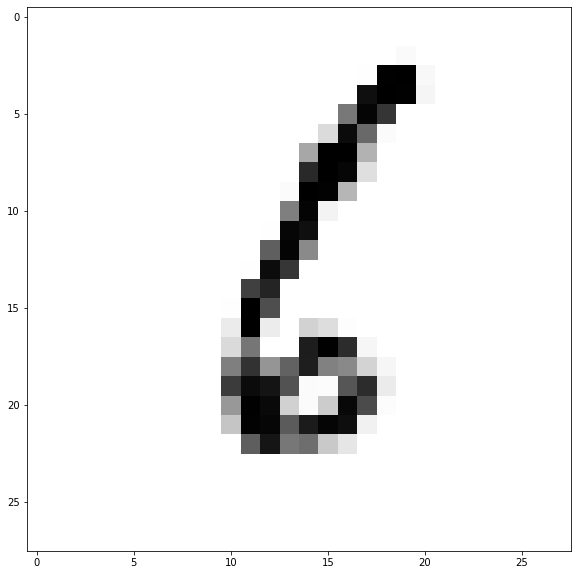

In [ ]:
generator.save("vanillaGAN.h5")
examples=100
noise = np.random.normal(0, 1, size=[examples, randomDim])
generatedImages = generator.predict(noise)
generatedImages = generatedImages.reshape(examples, 28, 28)
figsize=(10, 10)
plt.figure(figsize=figsize)
   
plt.imshow(generatedImages[6], interpolation='nearest', cmap='gray_r')
   

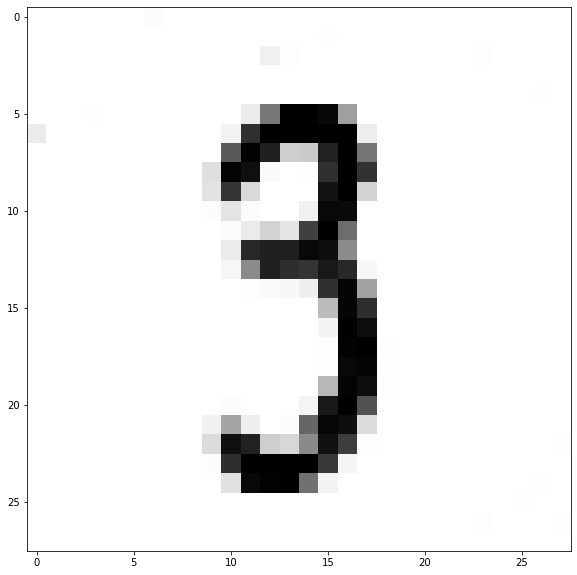

In [ ]:
noise = np.random.normal(0, 1, size=[examples, randomDim])
generatedImages = generator.predict(noise)
generatedImages = generatedImages.reshape(examples, 28, 28)
figsize=(10, 10)
plt.figure(figsize=figsize)
   
plt.imshow(generatedImages[6], interpolation='nearest', cmap='gray_r')